In [564]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

# SK learn stuff
from sklearn.feature_selection import mutual_info_regression
# from sklearn.ensemble import RandomForestRegressor # replaced this with XGBRegressor, which is several orders of magnitude faster
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
	"axes",
	labelweight="bold",
	labelsize="large",
	titleweight="bold",
	titlesize=14,
	titlepad=10,
)

# Utility functions from the Kaggle Tutorials
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

def fix_null_cols(X):
    # before we can do that we have to find and fix some null values showing up in numeric columns
    numeric_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

    null_col_sums = [X[i].isnull().sum() for i in numeric_cols]
    null_cols = [numeric_cols[i] for i in range(len(numeric_cols)) if null_col_sums[i] > 0]

    X_fixed = X[null_cols].fillna(value=0, inplace=False)
    X[null_cols] = X_fixed
    return X


def get_XGB_score(X, y):
    model = XGBRegressor()
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


In [565]:
# read in the data
df = pd.read_csv('data/train.csv', index_col=0)
df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [566]:
# let's first find a baseline score for this data, so we can see if we can improve it
X = df.copy()
X = fix_null_cols(X)

X.shape

(1460, 80)

In [567]:

# there are a few oddly low prices in the SalePrice
print(f"Mean Sale Price in training data: {X.SalePrice.mean()} \nMinimum sale price in training data: {X.SalePrice.min()}")


Mean Sale Price in training data: 180921.19589041095 
Minimum sale price in training data: 34900


In [568]:
y = X.pop('SalePrice')

score = get_XGB_score(X, y)

X['SalePrice'] = y
print(f"base RMSLE score with nothing modified other than dummies for categoricals: {score:.4f}")

base RMSLE score with nothing modified other than dummies for categoricals: 0.1432


In [569]:
# it seems there are either some split prices in the data, or some extremely odd prices that are far enough off the mean to potentially change our results
# let's filter out anything under $70000 for now. We can always compare later with the full dataset
X_filtered = X[X.SalePrice.gt(70000)].copy()
X_filtered.shape


(1438, 80)

In [570]:

# we ended up only removing 22 values, which is fine. We still have a substantial dataset but now we don't have extreme values impacting things
print(f"Mean Sale Price in training data: {X_filtered.SalePrice.mean()} \nMinimum sale price in training data: {X_filtered.SalePrice.min()}")

Mean Sale Price in training data: 182839.54033379693 
Minimum sale price in training data: 72500


In [571]:
y_filtered = X_filtered.pop('SalePrice')
score = get_XGB_score(X_filtered, y_filtered)
print(f"base RMSLE score with extremely low values filtered out: {score:.4f}")
X_filtered['SalePrice'] = y_filtered

base RMSLE score with extremely low values filtered out: 0.1305


As we can see, by removing those 22 extremely low prices, we have already massively improved our root mean square log error (RMSLE) score by around 7%, which is a big gain. It is an obvious benefit to ignore those values. Worst comes to worst, we can always include them later if we need.

In [572]:
# there's also a couple houses that are several times the mean and median prices that are extreme outliers for many features. we'll filter them out too
X_filtered = X_filtered[X_filtered.SalePrice.lt(600000)].copy()
X_filtered.shape


(1434, 80)

In [573]:
# that only ended up removing 4 houses but it makes a big impact on RMSLE
y_filtered = X_filtered.pop('SalePrice')
score = get_XGB_score(X_filtered, y_filtered)
print(f"base RMSLE score with extremely high values filtered out: {score:.4f}")
X_filtered['SalePrice'] = y_filtered


base RMSLE score with extremely high values filtered out: 0.1318


In [574]:
# I also found while digging in the data that there are several farms mixed in with the data, which isn't useful in context to comparing house prices, so let's remove that too
X_filtered = X_filtered[X_filtered.LotArea.lt(100000)].copy()
X_filtered.shape

(1430, 80)

In [575]:
y_filtered = X_filtered.pop('SalePrice')
score = get_XGB_score(X_filtered, y_filtered)
print(f"base RMSLE score with farms filtered out: {score:.4f}")
X_filtered['SalePrice'] = y_filtered

base RMSLE score with farms filtered out: 0.1280


In [576]:

# we'll stick with the filtered data as our dataset
X = X_filtered.copy()


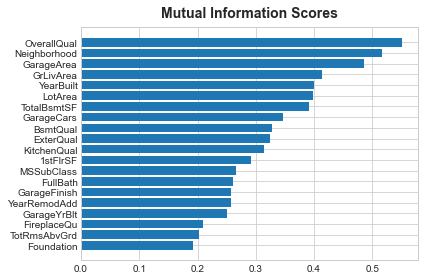

In [577]:
# Next we are going to find the mutual information scores for our training data
X_mi = X.copy()
y_mi = X_mi.pop('SalePrice')

mi_scores = make_mi_scores(X_mi, y_mi)
plot_mi_scores(mi_scores.head(20))

In [578]:
# from what we can see, living space features almost all score quite well. an overall score of all interior living area may be beneficial to the model so we'll add that and see if it helps
X_mi['TotalInteriorSF'] = X_mi['GrLivArea'] + X_mi['TotalBsmtSF'] + X_mi['GarageArea']


In [579]:
score = get_XGB_score(X_mi, y_mi)
print(f"RMSLE score with compound living area feature: {score:.4f}")

RMSLE score with compound living area feature: 0.1266


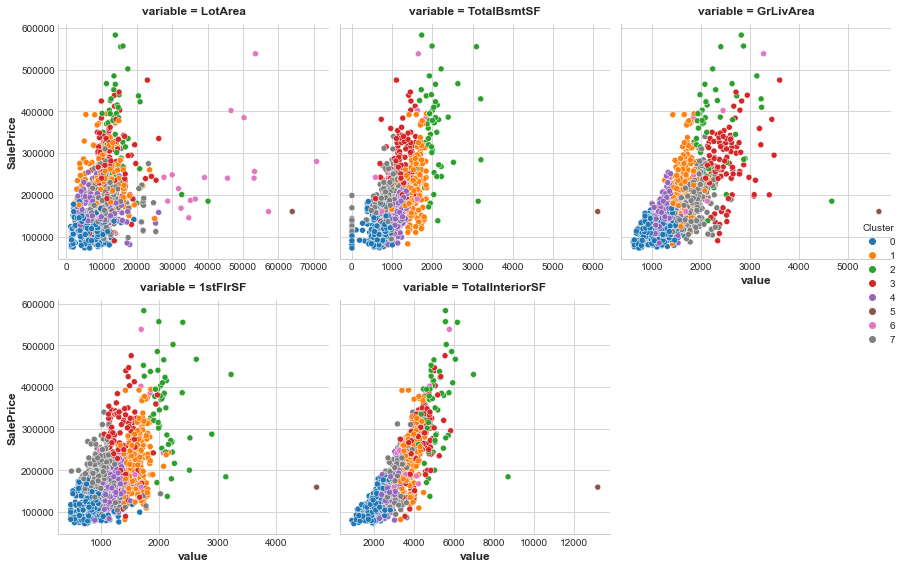

In [580]:
# the kaggle clustering example but tinkered with a bit since their example actually made MSLE worse

features = ["LotArea", "TotalBsmtSF", "GrLivArea", '1stFlrSF', 'TotalInteriorSF']

X_scaled = X_mi.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

kmeans = KMeans(n_clusters=8, random_state=0) # 10 clusters is the best result. anything above performs worse
X_mi["Cluster"] = kmeans.fit_predict(X_scaled)
X_mi["Cluster"] = X_mi["Cluster"].astype("category")

Xy = X_mi.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=Xy.melt(
        value_vars=features, id_vars=["SalePrice", "Cluster"],
    ),
);

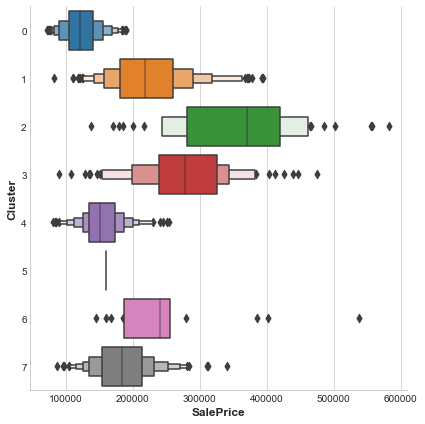

In [581]:
X_mi['SalePrice'] = y_mi
sns.catplot(x='SalePrice', y='Cluster', data=X_mi, kind='boxen', height=6)

In [582]:
X_mi.pop('SalePrice')
score = get_XGB_score(X_mi, y_mi)
print(f"RMSLE score with clustering added: {score:.4f}")

RMSLE score with clustering added: 0.1263


We only got a modest improvement from the clustering here, but it's an improvement non-the-less so we'll take it.

In [583]:
# so we removed 4 more entries, which is fine.